In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import sys
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import yaml
import requests
import requests
from io import BytesIO
from PIL import Image

from yolov9.models.yolo import Model
from yolov9.utils.augmentations import letterbox

%matplotlib inline

E:\Studies\Sem-8\REL301m\project\Object-Detection-Deep-Reinforcement-Learning\Dynamic\DQN_4layer_yolov9_backbone\yolov9\utils\general.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


In [2]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics 8.3.222  Python-3.11.13 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Setup complete  (20 CPUs, 31.6 GB RAM, 270.4/465.7 GB disk)


In [3]:
def load_image(img_path, target_size, url=False):
    if url:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        image = np.array(image)
    else:
        img_path = os.path.abspath(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB

    # resize img
    image = cv2.resize(image, target_size)

    image = np.asarray(image, dtype=np.uint8)

    return image

In [4]:
history_size = 1
# history_size = 5
action_option = 9
# max_steps = 20 # max steps
max_steps = 20 # max steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- PyTorch Model Definition ---
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        # self.fc3 = nn.Linear(1024, output_size)
        # add another layer
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # x = self.fc3(x)

        # with additional layer
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def create_q_model():
    feature_size = 512  # YOLOv9 backbone feature size
    input_size = feature_size + action_option * history_size
    output_size = action_option
    return QNetwork(input_size, output_size)

def create_feature_extractor(finetune: bool = False):
    """Create a YOLOv9 backbone feature extractor pre-trained on GDXray."""
    config_path = r'yolov9/models/detect/gelan-c.yaml'
    weights_path = r'weights/best.pt'
    
    # Load config
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Create full model
    model = Model(config, ch=3, nc=4)
    
    # Load weights
    if weights_path and os.path.exists(weights_path):
        ckpt = torch.load(weights_path, map_location="cpu", weights_only=False)
        model.load_state_dict(ckpt["model"].float().state_dict(), strict=False)
        print(f"Loaded YOLOv9 weights from {weights_path}")
    
    # Extract backbone
    feature_extractor = nn.Sequential(*model.model[:9])
    
    if finetune:
        for param in feature_extractor.parameters():
            param.requires_grad = True
        feature_extractor.train()
    else:
        for param in feature_extractor.parameters():
            param.requires_grad = False
        feature_extractor.eval()
    
    return feature_extractor

# --- PyTorch Feature Extraction ---
def extract_feature(image, history, feature_model):
    # 1. History feature (one-hot encoding of action history)
    history_feature = np.zeros(action_option * history_size, dtype=np.float32)
    for i in range(history_size):
        action = history[i]
        if action != -1:
            history_feature[i * action_option + action] = 1.0

    # 2. Image feature (YOLOv9 preprocessing dùng letterbox 640x640, chuẩn hóa, CHW)
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.ndim == 3 and image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)

    img_rgb = image.copy()
    img_letterbox, _, _ = letterbox(
        img_rgb,
        new_shape=(640, 640),
        auto=False,
        scaleFill=False,
        scaleup=False
    )

    img_letterbox = img_letterbox.astype(np.float32) / 255.0
    img_letterbox = np.ascontiguousarray(img_letterbox.transpose(2, 0, 1))
    input_tensor = torch.from_numpy(img_letterbox).unsqueeze(0).to(device)
    
    requires_grad = feature_model.training and any(param.requires_grad for param in feature_model.parameters())
    with torch.set_grad_enabled(requires_grad):
        feats = feature_model(input_tensor)
    
    pool = nn.AdaptiveAvgPool2d((1, 1))
    feats = pool(feats)
    feats = feats.view(feats.size(0), -1)

    image_feature = feats.detach().cpu().numpy().flatten().astype(np.float32)

    feature = np.concatenate((image_feature, history_feature))
    return feature[np.newaxis, :]

def compute_q(feature, deep_q_model):
    feature_tensor = torch.from_numpy(feature).float().to(device)
    with torch.no_grad():
        output = deep_q_model(feature_tensor)
    return output.cpu().numpy().flatten()


def compute_mask(action, current_mask):
    image_rate = 0.1
    delta_width = image_rate * (current_mask[2] - current_mask[0])
    delta_height = image_rate * (current_mask[3] - current_mask[1])
    dx1 = 0
    dy1 = 0
    dx2 = 0
    dy2 = 0

    if action == 0:
        dx1 = delta_width
        dx2 = delta_width
    elif action == 1:
        dx1 = -delta_width
        dx2 = -delta_width
    elif action == 2:
        dy1 = delta_height
        dy2 = delta_height
    elif action == 3:
        dy1 = -delta_height
        dy2 = -delta_height
    elif action == 4:
        dx1 = -delta_width
        dx2 = delta_width
        dy1 = -delta_height
        dy2 = delta_height
    elif action == 5:
        dx1 = delta_width
        dx2 = -delta_width
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 6:
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 7:
        dx1 = delta_width
        dx2 = -delta_width

    new_mask_tmp = np.array([current_mask[0] + dx1, current_mask[1] + dy1,
                         current_mask[2] + dx2, current_mask[3] + dy2])
    new_mask = np.array([
        min(new_mask_tmp[0], new_mask_tmp[2]),
        min(new_mask_tmp[1], new_mask_tmp[3]),
        max(new_mask_tmp[0], new_mask_tmp[2]),
        max(new_mask_tmp[1], new_mask_tmp[3])
    ])

    return new_mask


def crop_image(image, new_mask):
    height, width, channel = np.shape(image)
    new_mask = np.asarray(new_mask).astype("int")
    new_mask[0] = max(new_mask[0], 0)
    new_mask[1] = max(new_mask[1], 0)
    new_mask[2] = min(new_mask[2], width)
    new_mask[3] = min(new_mask[3], height)
    cropped_image = image[new_mask[1]:new_mask[3], new_mask[0]:new_mask[2]]
    new_height, new_width, new_channel = np.shape(cropped_image)

    if new_height == 0 or new_width == 0:
        return np.zeros((512, 512, 3), dtype=np.uint8)
    else:
        return cropped_image

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load feature extractor
feature_model = create_feature_extractor(finetune=False).to(device)

# load DQN model
deep_q = create_q_model().to(device)
deep_q_checkpoint = torch.load(r"weights_DQN_4layer_yolov9_max_step_20/best_model.pth", map_location=device)
deep_q.load_state_dict(deep_q_checkpoint['policy_net_state_dict'])

# load classification model
classification_model = YOLO(r'classify_yolov8_weights/best_5_class.pt')
# classification_model = YOLO(r'classify_yolov8_weights/best_2_class.pt')
# results = classification_model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

deep_q.eval()
feature_model.eval()
classification_model.eval()

def predict_mask(feature_model, deep_q, image):
    print(f"Processing Image...")
    history = [-1] * history_size
    height, width, channel = np.shape(image)
    current_mask = np.asarray([0, 0, width, height])
    feature = extract_feature(image, history, feature_model)
    
    end = False
    masks = []
    step = 0

    while not end:
        q_value = compute_q(feature, deep_q)
        action = np.argmax(q_value)

        history = history[1:]
        history.append(action)

        if action == 8 or step == max_steps:
            end = True
            new_mask = current_mask
        else:
            new_mask = compute_mask(action, current_mask)

        cropped_image = crop_image(image, new_mask)
        feature = extract_feature(cropped_image, history, feature_model)
        
        masks.append(new_mask)
        current_mask = new_mask
        step += 1

    mask = masks[-1] if masks else current_mask

    # Ensure mask is within image bounds
    mask[0] = max(mask[0], 0)
    mask[1] = max(mask[1], 0)
    mask[2] = min(mask[2], width)
    mask[3] = min(mask[3], height)
    
    return mask

def predict_class(classification_model, image, mask):
    cropped_image = crop_image(image, mask)
    results = classification_model.predict(source=cropped_image, conf=0.25)
    filter_probs = [k.item() for k in results[0].probs.top5conf if k.item() > 0.1]
    filter_classes = results[0].probs.top5[:len(filter_probs)]
    filter_classes_names = [results[0].names[k] for k in filter_classes]

    return filter_classes_names, filter_probs

def mask_image(image, mask, mean_color, noise_level=10):
    # masked the bbox area with mean of image
    masked_image = image.copy()
    x1, y1, x2, y2 = map(int, mask)
    # Đảm bảo tọa độ hợp lệ
    x1 = max(0, min(masked_image.shape[1], x1))
    x2 = max(0, min(masked_image.shape[1], x2))
    y1 = max(0, min(masked_image.shape[0], y1))
    y2 = max(0, min(masked_image.shape[0], y2))

    # mean color
    # masked_image[y1:y2, x1:x2] = mean_color

    # mean color with noise
    h = y2 - y1
    w = x2 - x1
    noise = np.random.randint(-noise_level, noise_level+1, size=(h, w, 3), dtype=np.int16)
    mean_arr = np.array(mean_color, dtype=np.int16).reshape(1, 1, 3)
    mask_value = np.clip(mean_arr + noise, 0, 255).astype(np.uint8)
    masked_image[y1:y2, x1:x2] = mask_value
    
    # red color
    # masked_image[y1:y2, x1:x2] = [255, 0, 0]

    # noise
    # masked_image[y1:y2, x1:x2] = np.random.randint(0, 256, size=(y2-y1, x2-x1, 3), dtype=np.uint8)
    
    # black color
    # masked_image[y1:y2, x1:x2] = [0, 0, 0]

    # print(f"Masking area: {mask} with color: {mean_color}")
    # print('Mean color:', mean_color)
    return masked_image

def predict_mask_and_class(feature_model, deep_q, classification_model, image):
    # mask list
    mask_class_prob = []

    # attempt to predict mask
    attempt = 3

    image_to_process = image.copy()

    # try multiple times to get a valid mask and class
    for i in range(attempt):
        mask = predict_mask(feature_model, deep_q, image_to_process)
        class_names, class_probs = predict_class(classification_model, image_to_process, mask)

        # Each time a mask is predicted, mask the area in the image for next attempt
        # mean color
        mean_color = [int(np.mean(image[:, :, i])) for i in range(3)]
        image_to_process = mask_image(image_to_process, mask, mean_color, 15)

        # if class names in ['blade', 'gun', 'knife', 'shuriken]
        if any(item in class_names for item in ['blade', 'gun', 'knife', 'shuriken']):
            mask_class_prob.append((mask, class_names, class_probs))
        # mask_class_prob.append((mask, class_names, class_probs))

    return mask_class_prob, image_to_process

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  1    212864  models.common.RepNCSPELAN4              [128, 256, 128, 64, 1]        
  3                -1  1    164352  models.common.ADown                     [256, 256]                    
  4                -1  1    847616  models.common.RepNCSPELAN4              [256, 512, 256, 128, 1]       
  5                -1  1    656384  models.common.ADown                     [512, 512]                    
  6                -1  1   2857472  models.common.RepNCSPELAN4              [512, 512, 512, 256, 1]       
  7                -1  1    656384  models.common.ADown                     [512, 512]                   

Loaded YOLOv9 weights from weights/best.pt


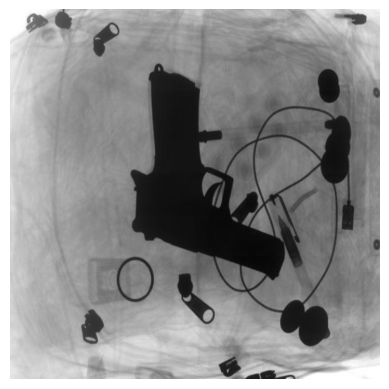

In [6]:
img_path = input('Enter image path or URL: ')
img = load_image(img_path, (640, 640))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# read image from url
img_url = 'https://image.made-in-china.com/365f3j00QaPEiJIdITlG/Airport-X-ray-Scanner-Baggage-Security-Check-Ce-ISO-Certification.webp'
img = load_image(img_url, (640, 640), url=True)
plt.imshow(img)
plt.axis('off')
plt.show()

Processing Image...
Predicted Mask: [115.2 115.2 524.8 524.8]


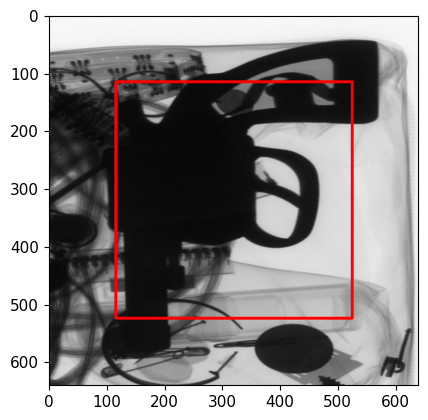

In [95]:
mask = predict_mask(feature_model, deep_q, img)
print("Predicted Mask:", mask)

im_to_show = img.copy()

# Convert bbox coordinates to integers
pt1 = (int(mask[0]), int(mask[1]))
pt2 = (int(mask[2]), int(mask[3]))

# Draw the predicted bounding box
cv2.rectangle(im_to_show, pt1, pt2, (255, 0, 0), 3) # red for predicted

plt.imshow(im_to_show)
# plt.axis('off') # Hide axes
plt.show()

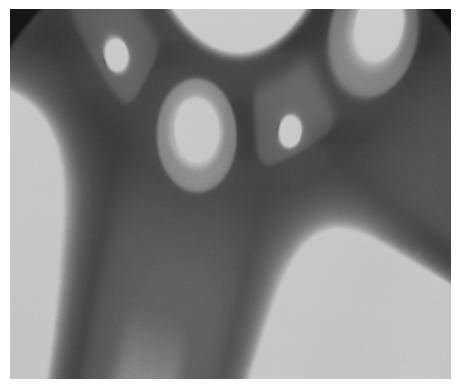


0: 128x128 no_object 1.00, shuriken 0.00, knife 0.00, gun 0.00, blade 0.00, 3.2ms
Speed: 1.8ms preprocess, 3.2ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
{0: 'blade', 1: 'gun', 2: 'knife', 3: 'no_object', 4: 'shuriken'}
[3, 4, 2, 1, 0]
tensor([1.0000e+00, 2.9814e-07, 2.0394e-07, 3.3612e-09, 4.4812e-10], device='cuda:0')


In [92]:
cropped_img = crop_image(img, mask)
plt.imshow(cropped_img)
plt.axis('off')
plt.show()
results = classification_model.predict(source=cropped_img)
print(results[0].names)
print(results[0].probs.top5)
print(results[0].probs.top5conf)

In [21]:
filter_probs = [k.item() for k in results[0].probs.top5conf if k.item() > 0.1]
filter_classes = results[0].probs.top5[:len(filter_probs)]
filter_classes_names = [results[0].names[k] for k in filter_classes]
print("Filtered Classes:", filter_classes_names)

Filtered Classes: ['shuriken']


In [12]:
import time

# Ghi lại thời gian bắt đầu
start_time = time.time()

mask_class_prob, image_to_process = predict_mask_and_class(feature_model, deep_q, classification_model, img)

end_time = time.time()

# Tính thời gian chạy
elapsed_time = end_time - start_time
print(f"Thời gian chạy: {elapsed_time:.4f} giây")
print(f"Thời gian chạy: {elapsed_time:.2f} giây")

Processing Image...

0: 128x128 gun 1.00, shuriken 0.00, blade 0.00, knife 0.00, no_object 0.00, 2.9ms
Speed: 2.4ms preprocess, 2.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Processing Image...

0: 128x128 no_object 0.97, gun 0.02, blade 0.00, shuriken 0.00, knife 0.00, 2.7ms
Speed: 1.6ms preprocess, 2.7ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Processing Image...

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 2.6ms
Speed: 2.7ms preprocess, 2.6ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Thời gian chạy: 0.9627 giây
Thời gian chạy: 0.96 giây


Processing Image...

0: 128x128 gun 1.00, shuriken 0.00, blade 0.00, knife 0.00, no_object 0.00, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 0.2ms postprocess per image at shape (1, 3, 128, 128)
Processing Image...

0: 128x128 no_object 0.98, gun 0.01, blade 0.00, shuriken 0.00, knife 0.00, 3.5ms
Speed: 1.7ms preprocess, 3.5ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Processing Image...

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 2.8ms
Speed: 2.3ms preprocess, 2.8ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)


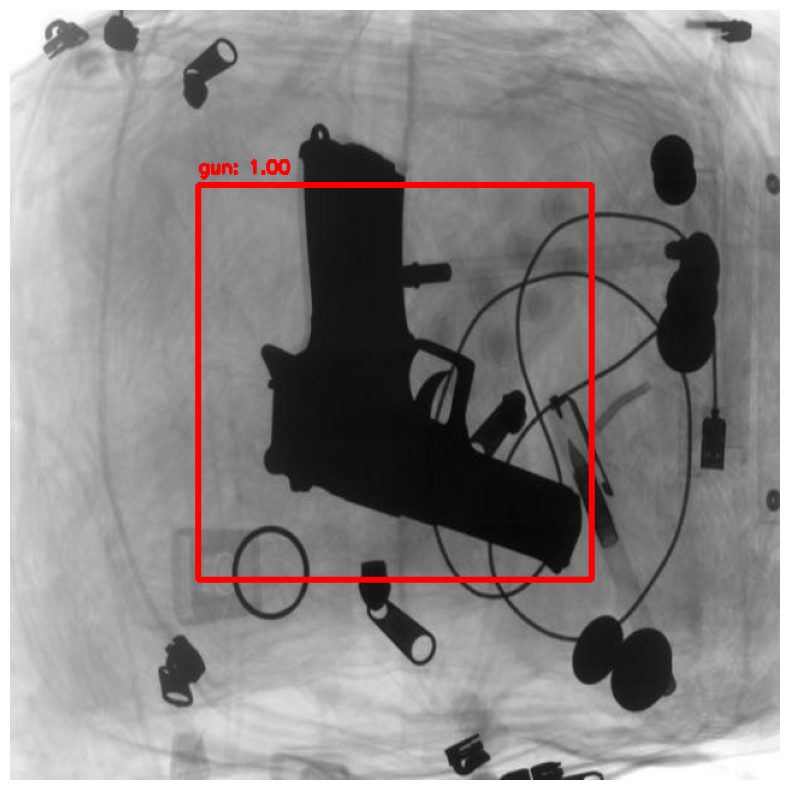

In [11]:
mask_class_prob, image_to_process = predict_mask_and_class(feature_model, deep_q, classification_model, img)

im_to_show = img.copy()

plt.figure(figsize=(10, 10))

for idx, (mask, class_names, class_probs) in enumerate(mask_class_prob):
    # Convert bbox coordinates to integers
    pt1 = (int(mask[0]), int(mask[1]))
    pt2 = (int(mask[2]), int(mask[3]))

    # Draw the predicted bounding box and class label
    cv2.rectangle(im_to_show, pt1, pt2, (255, 0, 0), 3) # red for predicted
    cv2.putText(im_to_show, f"{class_names[0]}: {class_probs[0]:.2f}", (pt1[0], pt1[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.imshow(im_to_show)
plt.axis('off') # Hide axes
plt.show()

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

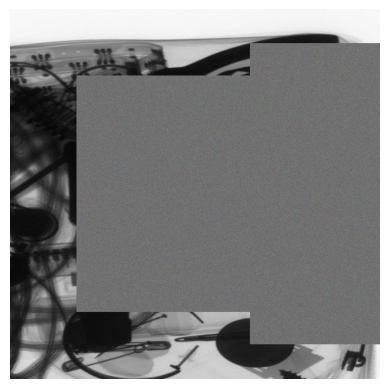

In [97]:
plt.imshow(image_to_process)
plt.axis('off')

In [98]:
mask_class_prob

[(array([115.2, 115.2, 524.8, 524.8]), ['gun'], [0.9999998807907104]),
 (array([415.25248   ,  59.08073677, 640.        , 580.91926323]),
  ['no_object'],
  [0.9987687468528748]),
 (array([646.144,   0.   , 640.   , 640.   ]),
  ['shuriken'],
  [0.9774343967437744])]

In [16]:
import cv2
import numpy as np

video_path = 'test.mp4'
output_path = 'output_1fps.mp4'
frame_size = (640, 640)
frame_interval_ms = 1000
output_fps = 1

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Không mở được file video đầu vào: {video_path}")

out = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*'mp4v'),
    output_fps,
    frame_size
)
if not out.isOpened():
    cap.release()
    raise RuntimeError(f"Không mở được file video đầu ra: {output_path}")

last_written_ms = -frame_interval_ms
frame_idx = 0
fallback_fps = cap.get(cv2.CAP_PROP_FPS)
if fallback_fps <= 0:
    fallback_fps = output_fps

try:
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            break
        if frame_bgr is None:
            frame_idx += 1
            continue

        if frame_bgr.shape[1] != frame_size[0] or frame_bgr.shape[0] != frame_size[1]:
            frame_bgr = cv2.resize(frame_bgr, frame_size)

        timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        if timestamp_ms <= 0:
            timestamp_ms = frame_idx * (1000.0 / fallback_fps)

        if timestamp_ms - last_written_ms >= frame_interval_ms - 1:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

            mask = predict_mask(feature_model, deep_q, frame_rgb)
            class_names, class_probs = predict_class(classification_model, frame_rgb, mask)

            x1, y1, x2, y2 = [int(v) for v in mask]
            x1 = max(0, min(frame_size[0] - 1, x1))
            y1 = max(0, min(frame_size[1] - 1, y1))
            x2 = max(0, min(frame_size[0] - 1, x2))
            y2 = max(0, min(frame_size[1] - 1, y2))

            annotated = frame_bgr.copy()
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 0, 0), 3)
            if class_names and class_probs:
                label = f"{class_names[0]}: {class_probs[0]:.2f}"
                cv2.putText(
                    annotated,
                    label,
                    (x1, max(0, y1 - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 0, 0),
                    2
                )

            out.write(annotated)
            last_written_ms = timestamp_ms

        frame_idx += 1
finally:
    cap.release()
    out.release()

print(f"Đã lưu video đã xử lý tại: {output_path}")

Processing Image...

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 2.7ms
Speed: 2.4ms preprocess, 2.7ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 2.7ms
Speed: 2.4ms preprocess, 2.7ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Processing Image...
Processing Image...

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 3.9ms
Speed: 2.3ms preprocess, 3.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 3.9ms
Speed: 2.3ms preprocess, 3.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)
Processing Image...
Processing Image...

0: 128x128 no_object 1.00, knife 0.00, blade 0.00, shuriken 0.00, gun 0.00, 2.9ms
Speed: 2.5ms preprocess, 2.9ms inference, 0.1ms postprocess per image at shape (1, 3, 128, 128)

0: 1